In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import sys

try:
    ROOT = Path().resolve().parents[1]
    assert (ROOT / "common").exists()
except AssertionError:
    ROOT = next(p for p in Path().resolve().parents if (p / "common").exists())

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [3]:
#print(ROOT)

In [4]:
from common import sensors as sn 
from common import subspace_methods as sm
from common import em_tools as em
from common import log_funcs as lf

In [5]:
DIST_RATIO = 0.5

In [6]:
Num_sensors1 = 20
Num_emitters1 = 2
sample_size1 = 30

failing_sensors1 = np.arange(4)
gap_ratio1 = 0.4 * np.ones_like(failing_sensors1, dtype=np.float32)

theta1_rad = np.array([-0.5, 0.7]) # Угловые координаты источников (DoA) в радианах
theta1_deg = np.rad2deg(theta1_rad) # Угловые координаты источников (DoA) в градусах

signal_1_db = -4
signal_2_db = 2
noise_db = 4

signal_1_var = sn.db_to_var(signal_1_db)
signal_2_var = sn.db_to_var(signal_2_db)
noise_var = sn.db_to_var(noise_db)

P1 = np.diag([signal_1_var, signal_2_var]) # Ковариация сигналов
Q1 = noise_var * np.eye(Num_sensors1, dtype=np.float64) # Ковариация шумов
A1 = (np.exp(-2j * np.pi * DIST_RATIO * np.arange(Num_sensors1).reshape(-1,1) * 
             np.sin(theta1_rad))) # Матрица векторов направленности
# Генерация сигналов, шумов и наблюдений
S1 = sn.gss(Num_emitters1, sample_size1, P1)
N1 = sn.gss(Num_sensors1, sample_size1, Q1)
X1 = (A1 @ S1.T + N1.T).T
X1_with_mv = sn.MCAR(X1, failing_sensors1, gap_ratio1)
R1 = sn.initial_Cov(X1_with_mv)
MUSIC_theta1 = sm.MUSIC_DoA(R1, Num_emitters1)
#MUSIC_theta1 = np.array([-0.4, 0.75])

In [7]:
print(f"theta1_rad={theta1_rad}")
print(f"P1={P1}")

theta1_rad=[-0.5  0.7]
P1=[[0.39810717 0.        ]
 [0.         1.58489319]]


In [8]:
print(f"MUSIC_theta1={MUSIC_theta1}")

MUSIC_theta1=[-0.50614548  0.6981317 ]


In [9]:
sn.SNR(A1, P1, Q1, metrics = 'avg', scale = 'linear')

np.float64(7.9038437865326046)

In [10]:
EM_theta1_rad, EM_P1, lhd_1, lhd_list1, angles_list1 = em.multistart_EM(X1_with_mv, 
                                                                        Num_emitters1, 
                                                                        Q=Q1,
                                                                        theta_guess=MUSIC_theta1, 
                                                                        num_of_starts=1, 
                                                                        max_iter=50, 
                                                                        rtol_params=1e-3,
                                                                        rtol_lkhd=1e-5,
                                                                        reg_coef=1e-6,
                                                                        debug=False)

0-th start
theta=[-0.50614548  0.6981317 ],P=[[0.05883301-8.93161380e-20j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.17165205-4.03620891e-18j]]
Inital likelihood = -1279.274328364249
Iteration=1
new_angles=[-0.50307756  0.69717598]
likelihood is -1256.1293499041126 on iteration 1.
Iteration=2
new_angles=[-0.50326432  0.69678585]
likelihood is -1173.8852768384936 on iteration 2.
Iteration=3
new_angles=[-0.50361272  0.69654711]
likelihood is -1168.8950991582365 on iteration 3.
Iteration=4
new_angles=[-0.50392634  0.69638798]
likelihood is -1173.0491895817972 on iteration 4.
Accumulation of floating-point errors, likelihood started to decrease!
best_start=0
Время выполнения функции: 3.155588 секунд


In [11]:
EM_theta1_rad, EM_P1

(array([-0.50361272,  0.69654711]),
 array([[ 0.52129171+0.j        , -0.12481684-0.05253846j],
        [-0.12481684+0.05253846j,  2.73638587+0.j        ]]))

In [12]:
angles_list1

[array([-0.50614548,  0.6981317 ]),
 array([-0.50307756,  0.69717598]),
 array([-0.50326432,  0.69678585]),
 array([-0.50361272,  0.69654711])]

In [13]:
np.array(angles_list1)

array([[-0.50614548,  0.6981317 ],
       [-0.50307756,  0.69717598],
       [-0.50326432,  0.69678585],
       [-0.50361272,  0.69654711]])

In [14]:
lf.incomplete_lkhd(X1_with_mv, EM_theta1_rad, EM_P1, Q1), lf.incomplete_lkhd(X1_with_mv, theta1_rad, P1, Q1)

(np.float64(-1168.8950991582365), np.float64(-1167.2633818949887))

In [15]:
lhd_list1 = np.array(lhd_list1)
angles_list1 = np.rad2deg(np.array(angles_list1))
x1 = np.arange(len(angles_list1))

In [16]:
x_grid = np.arange(1,52,5)

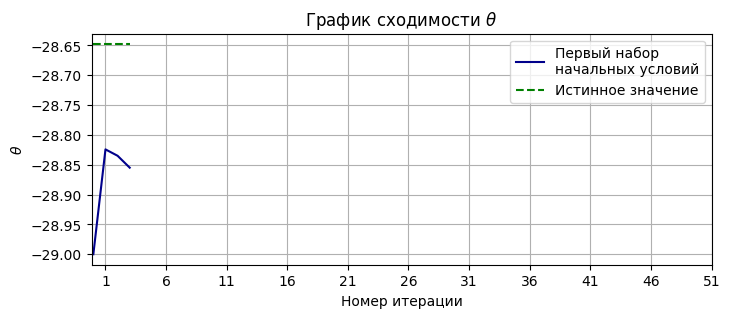

In [17]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x1, angles_list1[:,0],color='darkblue', label=f'Первый набор\nначальных условий')
plt.plot(x1, np.tile(theta1_deg[0], angles_list1.shape[0]), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

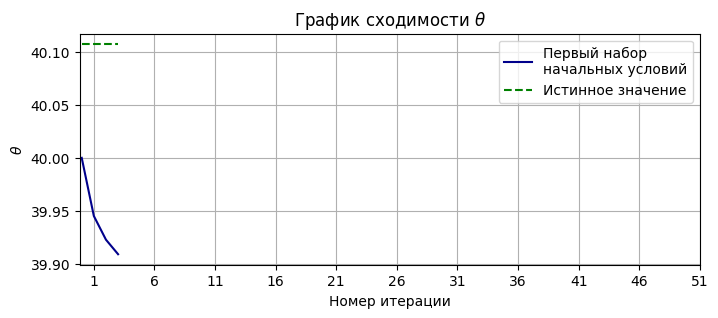

In [18]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x1, angles_list1[:,1],color='darkblue', label=f'Первый набор\nначальных условий')
plt.plot(x1, np.tile(theta1_deg[1], angles_list1.shape[0]), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

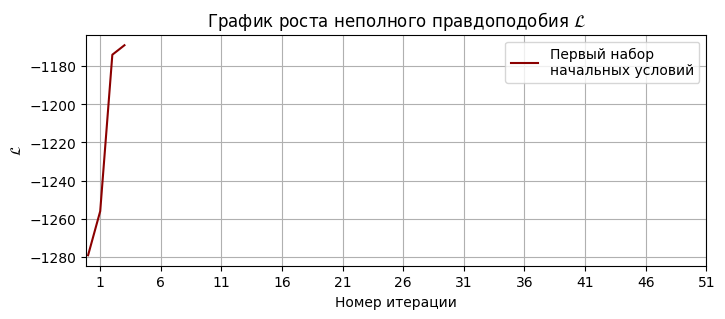

In [19]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График роста неполного правдоподобия} \,\,\mathcal{L}$')
plt.plot(x1, lhd_list1, color='darkred', label=f'Первый набор\nначальных условий')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\mathcal{L}$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()